Neural style transfer is an optimization technique used to take two images—a **content image** and a **style reference image** (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

In this kernel, I have implemented the style trasnfer method outlined in the papers [Image Style Transfer Using Convolution Neural Networks](https://ieeexplore.ieee.org/document/7780634) and [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf).

Style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. The convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.

### Distinguishing Style and Content
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, target image which should contain our desired content and style components:

*   Objects and their arrangement are similar to that of the **content image**.
*   Style, colors, and textures are similar to that of the **style image**.


In [1]:
#Importing the dependent libraries

import numpy as np 
import pandas as pd 

import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Colab Notebooks/Neural Style Transfer

/content/drive/My Drive/Colab Notebooks/Neural Style Transfer


In [4]:
content_path='/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/csgo.jpg'
style_path = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/starrynight.jpg'

In [5]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a 
                                               #batch of single image 
    return im_array

In [6]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [7]:
content = load_file(content_path)
style = load_file(style_path) 

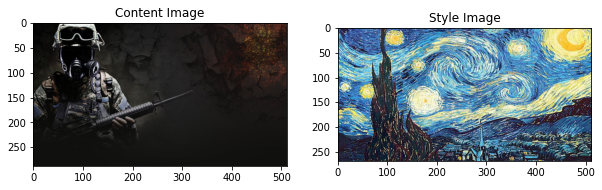

In [8]:
plt.figure(figsize=(10,10))
#content = load_file(content_path)
#style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [9]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [10]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [12]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [13]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [14]:
model=get_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [15]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

In [16]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [17]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss

In [18]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

In [19]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

In [20]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [21]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

In [22]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [23]:
def run_style_transfer(content_path,style_path,epochs=30,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs


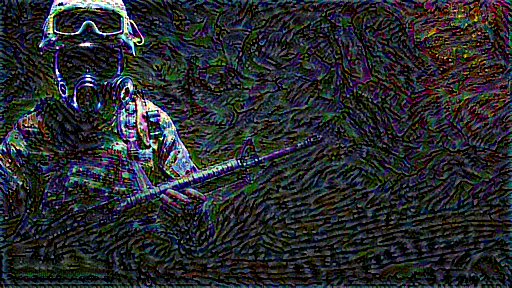

Epoch: 25
Total loss: 4.3978e+07, style loss: 4.1339e+07, content loss: 2.6394e+06, 


In [24]:
best, best_loss,image = run_style_transfer(content_path, 
                                     style_path, epochs=30)

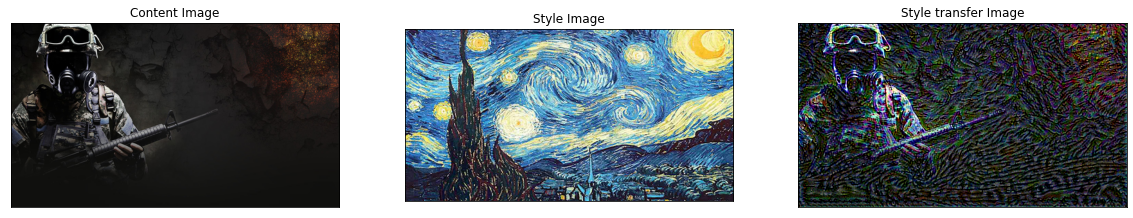

In [25]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.savefig('best')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.savefig('content')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.savefig('style')
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig()